In [1]:
############
# Packages #
############
import time as t

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy as sp
import random
from numba import jit
from typing import Dict, Union, List, Tuple, Any, Callable, Optional
###################
# hyperparametres #
###################

# for reproductibility
seed = 0

# data dimensions
T=200
k=100
l =0

#Z : (k,1)
#Y : (T,1)
#U : (T,l)
#X : (T,k)

# data generations

# for X:
rho=0.75

# for Beta : number of non null
s=5 #in [5,10,100]
lst_s = [5,10,100]

# for sigma2 :ratio between explained and total variance 
Ry=0.02 #in [0.02, 0.25, 0.5]
lst_Ry = [0.02, 0.25, 0.5]

# for q prior
a=1
b=1

# for R2 prior
A=1
B=1

### Initialize parameters

Firstly, let's comput the initialization of the parameters

In [2]:
def compute_X(T, k, rho):
    """Compute matrix of xt observations

    Args:
        T (int): number of observations
        k (int): number of xt predictors
        rho (float): Toeplitz correlation parameter

    Returns:
        np.array: dimensions T*k
    """
    cov_matrix=np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            cov_matrix[i,j]=rho**np.abs(i-j)
    return np.random.multivariate_normal([0]*k, cov_matrix, T)

def compute_U(T, l):
    """Compute matrix of ut observations

    Args:
        T (int): number of observations
        l (int): number of ut predictors

    Returns:
        int: 0
    """
    if l==0:
        return 0
    else:
        pass
        
def compute_vx(X):
    """Compute mean estimated variance of xt predictors

    Args:
        X (np.array): matrix of xt predictors

    Returns:
        float: mean estimated variance of xt predictors
    """
    return np.mean(np.var(X,axis=0))

def sample_beta(k, s):
    """Sample of beta vector of dimensions 1*k

    Args:
        k (int): number of predictors
        s (int): number of non-zero elements of beta

    Returns:
        np.array: dimensions 1*k
    """
    beta=np.zeros(k)
    index_normal_distribution=np.random.choice(len(beta), size=s, replace=False)
    beta[index_normal_distribution] = np.random.normal(loc=0, scale=1, size=s)
    return beta

def sample_phi(l):
    """Sample phi prior

    Args:
        l (int): number of ut predictors

    Returns:
        int or np.array: phi samples
    """
    if l==0:
        return 0
    else:
        return np.random.uniform(0,1, size=l)

def compute_Z(beta):
    """Compute z_1,...,z_k

    Args:
        beta (np.array): random vector beta

    Returns:
        np.array: dimensions1*k
    """
    Z=beta
    Z[Z!=0]=1
    return Z

def compute_sigma2(Ry, beta, X):
    """ Compute sigma2
    Args:
        Ry (float): pourcentage of explained variance
        beta (np.array): random vector beta
        X (np.array): matrix of xt predictors

    Returns:
        float: dimensions 1*1
    """
    return (1/Ry-1)*np.mean(np.square(X @ beta))

def sample_R2(A,B):
    """Sample R^2 according to a beta distribution

    Args:
        A (float): shape parameter
        B (float): shape parameter

    Returns:
        float: R^2 random variable
    """
    return np.random.beta(A,B)

def sample_q(a,b):
    """Sample q according to a beta distribution

    Args:
        a (float): shape parameter
        b (float): shape parameter

    Returns:
        float: q random variable
    """
    return np.random.beta(a,b)

@jit(nopython=True)
def compute_gamma2(R2, q, k, vx):
    """Compute gamma^2 by inverting the R^2 function

    Args:
        R2 (float): R^2 random variable
        q (float): q random variable
        k (int): number of xt predictors
        vx (float): mean estimated variance of xt predictors

    Returns:
        float: gamma^2 random variable
    """
    return R2/((1-R2)*q*k*vx)

def sample_epsilon(T, sigma2):
    """Sample epsilon_1,...,epsilon_T

    Args:
        T (int): number of observations
        sigma2 (float): sigma2 previously sampled

    Returns:
        np.array: dimensions 1*T
    """
    return np.random.normal(loc=0, scale=sigma2, size=T)

def compute_Y(X, beta, epsilon):
    """Compute y_1,...,y_T

    Args:
        X (np.array): matrix of xt predictors
        beta (np.array): random vector beta
        epsilon (np.array): vector of epsilon_1,...,epsilon_T

    Returns:
        np.array: dimensions 1*T
    """
    return X@beta + epsilon


### Final function
def init_parameters(seed, T, k, l, rho, s, Ry, a, b, A, B):
    """
    Initialize parameters for a given simulation.

    Args:
        seed (int): Seed for reproducibility.
        T (int): Number of observations.
        k (int): Number of covariates.
        l (int): Number of latent variables.
        rho (float): Correlation parameter.
        s (float): Scaling parameter.
        Ry (float): Response variance.
        a (float): Shape parameter for gamma2.
        b (float): Shape parameter for gamma2.
        A (float): Shape parameter for q.
        B (float): Shape parameter for q.

    Returns:
        dict: Dictionary containing initialized parameters.
    """
    np.random.seed(seed=seed)
    dct = {
        "X" : compute_X(T=T, k=k, rho=rho),
        "U": compute_U(T=T, l=l),
        "beta": sample_beta(k=k, s=s),
        "phi": sample_phi(l=l),
        "q": sample_q(a,b)
    }
    dct["R2"] = sample_R2(A,B)
    dct["gamma2"]=compute_gamma2(R2=dct["R2"], q=dct["q"], k=k, vx=compute_vx(dct["X"]))
    dct["Z"]=compute_Z(beta=dct["beta"])
    dct["sigma2"] = compute_sigma2(Ry=Ry, beta=dct["beta"], X=dct["X"])
    dct["epsilon"] = sample_epsilon(T=T, sigma2=dct["sigma2"])
    dct["Y"]=compute_Y(X=dct["X"], beta=dct["beta"], epsilon=dct["epsilon"])
    return dct

In [3]:
dct = init_parameters(seed,T,k,l,rho,s,Ry,a,b,A,B)

### Vectorization

In order to take advantage of the processor architecture, we're reducing ourselves to matrix manipulation and using just-in-time compilation by numba. So we're going to group all the information together in an array called data.

In [4]:
def vectorize_data(dct: Dict[str, np.ndarray], 
                   seed: int, 
                   T: int, 
                   k: int, 
                   l: float, 
                   a: float, 
                   b: float,
                   A: float, 
                   B: float) -> np.ndarray:
    """
    Vectorize data from a dictionary and additional parameters.

    Parameters:
        dct (Dict[str, np.ndarray]): Dictionary containing data arrays.
        seed (int): Random seed.
        T (int): Number of time points.
        k (int): Number of components.
        l (float): Some parameter.
        a (float): Some parameter.
        b (float): Some parameter.
        A (float): Some parameter.
        B (float): Some parameter.

    Returns:
        np.ndarray: Vectorized data array.
    """
    
    data = np.zeros((k+3, T))
    
    data[0,0]=k
    data[0,1]=l
    data[0,2]=a
    data[0,3]=b
    data[0,4]=A
    data[0,5]=B
    data[0,6]=seed
    
    data[0,7]=compute_vx(dct["X"])
    data[0,8]=dct["R2"]
    data[0,9]=dct["q"]
    data[0,10]=dct["gamma2"]
    data[0,11]=dct["sigma2"]
    
    data[1,:]=dct["Y"]
    data[2,:k] = dct["Z"]
    data[2,k:] = dct["beta"]
    data[3:,:] = dct["X"].T
    
    return data

We save the simulated data, which will be used as a basis for building posterior distributions.

In [5]:
data0 = vectorize_data(dct,seed,T,k,l,a,b,A,B)

## 1. Draw from the conditional posterior of $(R^2, q)$

After discretizing the support of $(R^2, q)$, we use the inverse transform sampling method to simulate the a posteriori distribution of the pair of variables

In [6]:
@jit(nopython=True)
def R2_q_flatted_grid(grid: np.ndarray) -> np.ndarray:
    """
    Flatten a 2D grid of parameters (grid) into a 2D array where each row
    represents a pair of parameters (R2, q).

    Parameters:
        grid (np.ndarray): 1D array representing a 2D grid of parameters.

    Returns:
        np.ndarray: 2D array with two columns representing pairs of parameters (R2, q).
    """
    n_pas = len(grid)
    R_q = np.zeros((n_pas**2, 2))
    for i in range(n_pas):
        for j in range(n_pas):
            R_q[i*n_pas+j,0] = grid[i]
            R_q[i*n_pas+j,1] = grid[j]
    return R_q

@jit(nopython=True)
def get_R2_q_grid() -> np.ndarray:
    """
    Generate a 2D grid of parameters (R2, q) with specified discretization.

    Returns:
        np.ndarray: 2D array with two columns representing pairs of parameters (R2, q).
    """
    arr0 = np.arange(0.001,0.101,0.001) # does not start at 0 because division by 0 otherwise
    arr1 = np.arange(0.11,0.91,0.01)
    arr2 = np.arange(0.901,1,0.001)
    discretization =  np.concatenate((arr0, arr1, arr2), axis=0)
    return R2_q_flatted_grid(discretization)

In [7]:
print(get_R2_q_grid())

[[0.001 0.001]
 [0.001 0.002]
 [0.001 0.003]
 ...
 [0.999 0.997]
 [0.999 0.998]
 [0.999 0.999]]


Some stabilisation tricks were necessary to avoid numerical errors, such as switching to the logarithm.

In [8]:
def get_R2_q_densities(data: np.ndarray, grid: np.ndarray) -> np.ndarray:
    """
    Calculate densities for a 2D parameter grid (R2, q) given data.

    Args:
        data (np.ndarray): Array containing the data.
        grid (np.ndarray): 2D array representing the parameter grid.

    Returns:
        np.ndarray: Array of densities corresponding to the parameter grid.
    """
    k=int(data[0,0])
    R2 = grid[:,0]
    q = grid[:,1]
    s_z = np.sum(data[2,:k]) #z
    
    log_weights = - np.prod([
        1/(1e-6 + 2*data[0,11]),#sigma2
        (k*data[0,7]*q*(1-R2))/(1e-8 + R2), #vx
         np.dot(data[2,k:], np.dot(np.diag(data[2,:k]), data[2,k:])) #beta z beta
        ])
    log_weights += (s_z+s_z/2+data[0,2]-1)*np.log(q) #a
    log_weights += (k-s_z+data[0,3]-1)*np.log(1-q) #b
    log_weights += (data[0,4]-1-s_z/2)*np.log(R2) #A
    log_weights += (s_z/2+data[0,5]-1)*np.log(1-R2)#B
    
    #stabilisation:
    log_weights -= max(log_weights)
    
    weights = np.exp(log_weights)
    return weights/weights.sum()


In [9]:
print(get_R2_q_densities(data0, get_R2_q_grid()))

[6.45590617e-011 4.53853916e-009 3.68801786e-008 ... 1.09450645e-242
 2.05974623e-259 5.23872813e-288]


c:\Users\yanis\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [10]:
def sample_R2_q_post(grid: np.ndarray, data: np.ndarray, npoints: int) -> np.ndarray:
    """
    Sample from the posterior distribution of R2 and q using a grid-based approach.

    Args:
        grid (np.ndarray): Grid of R2 and q values.
        data (np.ndarray): Observed data.
        npoints (int): Number of points to sample.

    Returns:
        np.ndarray: Samples from the posterior distribution.
    """
    densities = get_R2_q_densities(data, grid)
    index = np.random.choice(np.arange(grid.shape[0]), npoints, p=densities)
    return grid[index,:]

def plot_hist(sample, title):
    fig = px.histogram(sample,
                   histnorm='probability density',
                   title = title,
                   template="plotly_dark",
                   nbins = 400
                  )
    fig.show()

On obtient une distribution partielle en raison de notre maillage qui est inégalement répartie.

In [11]:
plot_hist(sample_R2_q_post(get_R2_q_grid(),data0, 10000), 
          f"<b>First sample from the conditional posterior of R2 and q</b> <br>R2 in blue and q in red"
         )

## 3. Sample from the conditional posterior of $z$

We build the blocks for sampling $z_i|Y, U, X, ϕ, R^2, q, z_{−i}$ which, once assembled, will allow us to build a Gibbs sampler for the posterior distribution of $z$. To do this, we identify the non-zero values of $z$ to calculate $\tilde{X}$ and then $\tilde{W}$. Then we take advantage of certain simplifications, given that $U=0$, to calculate the parameter of the binomial distribution of each $z_i$. Once again, we use the logarithm to avoid numerical errors.

In [12]:
@jit(nopython=True)
def compute_X_and_W_tilde(z: np.ndarray, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute X_tilde_t and W_tilde based on binary variable z and observed data.

    Args:
        z (np.ndarray): Binary variable z.
        data (np.ndarray): Observed data.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple containing X_tilde_t and W_tilde.
    """
    non_zero_z=np.nonzero(z)[0]
    I_s_z=np.identity(non_zero_z.shape[0])
    X_tilde_t = data[3+non_zero_z,:] 
    W_tilde = X_tilde_t@X_tilde_t.T+(1/data[0,10])*I_s_z #gamma2
    return X_tilde_t, W_tilde

@jit(nopython=True)
def yy_minus_betah_w_betah(X_tilde_t: np.ndarray, W_tilde: np.ndarray, data: np.ndarray) -> float:
    """
    Calculate the quantity y.Ty - beta_hat_tilde^T * W_tilde * beta_hat_tilde.

    Args:
        X_tilde_t (np.ndarray): X_tilde transpose matrix.
        W_tilde (np.ndarray): W_tilde matrix.
        data (np.ndarray): Observed data.

    Returns:
        float: The calculated quantity yy - beta^T * W_tilde * beta.
    """
    xy = X_tilde_t @ data[1,:]
    return data[1,:].T @ data[1,:] -(xy.T @ np.linalg.inv(W_tilde) @ xy)


@jit(nopython=True)
def zi_densities(i: int, data: np.ndarray) -> np.ndarray:
    """
    Calculate the densities for binary variable z_i using a specific index.

    Args:
        i (int): Index of the variable z_i.
        data (np.ndarray): Observed data.

    Returns:
        np.ndarray: Normalized densities for z_i.
    """
    zi = np.arange(2)
    log_weights = zi*(np.log(data[0,9])-np.log(1-data[0,9]))-(zi/2)*np.log(data[0,10])# q gamma2
    z = data[2,:k].copy()
    for zi in range(2):
        z[i] = zi
        X_tilde_t, W_tilde = compute_X_and_W_tilde(z, data)
        sign, logabsdet = np.linalg.slogdet(W_tilde)
        log_weights[zi] -= (1/2)*sign*logabsdet
        log_weights[zi] -= (data.shape[1]/2)* np.log(  yy_minus_betah_w_betah(X_tilde_t, W_tilde, data) )
    
    #stabilisation
    log_weights -= np.min(log_weights)
    
    weights = np.exp(log_weights)
    
    return weights/weights.sum()    

In [13]:
print(zi_densities(0,data0))

[0.9286497 0.0713503]


In [14]:
@jit(nopython=True)
def sample_zi(i: int, data: np.ndarray) -> int:
    """
    Sample the value of zi given the observed data.

    Args:
        i (int): Index for which zi is sampled.
        data (np.ndarray): Observed data.

    Returns:
        int: The sampled value of zi (0 or 1).
    """
    if np.random.rand()<zi_densities(i, data)[0]:
        return 0
    return 1

A terme nous réalisons un Gibbs sampler par tirage et mise à jours successifs des zi. 

In [15]:
# @jit(nopython=True)
# def gibbs_z(data: np.ndarray, n_iter: int, return_all_steps: bool, seed: int) -> None:
#     """
#     Gibbs sampling to update the values of zi in the observed data.

#     Args:
#         data (np.ndarray): Observed data.
#         n_iter (int): Number of Gibbs sampling iterations.
#     """
#     random.seed(seed)
#     k=int(data[0,0])
#     if return_all_steps:
#         sampled_z=[]
#         for j in range(n_iter):
#             sampled_z_i=[]
#             for i in range(k):
#                 zi = sample_zi(i, data)
#                 data[2,i] = zi
#                 sampled_z_i.append(zi)
#             sampled_z.append(sampled_z_i)
#         return sampled_z
#     else:
#         for j in range(n_iter):
#             for i in range(k):
#                 data[2,i] = sample_zi(i, data)

In [41]:
@jit(nopython=True)
def gibbs_z(data: np.ndarray, n_iter: int) -> None:
    """
    Gibbs sampling to update the values of zi in the observed data.

    Args:
        data (np.ndarray): Observed data.
        n_iter (int): Number of Gibbs sampling iterations.
    """
    k=int(data[0,0])

    for j in range(n_iter):
        for i in range(k):
            data[2,i] = sample_zi(i, data)

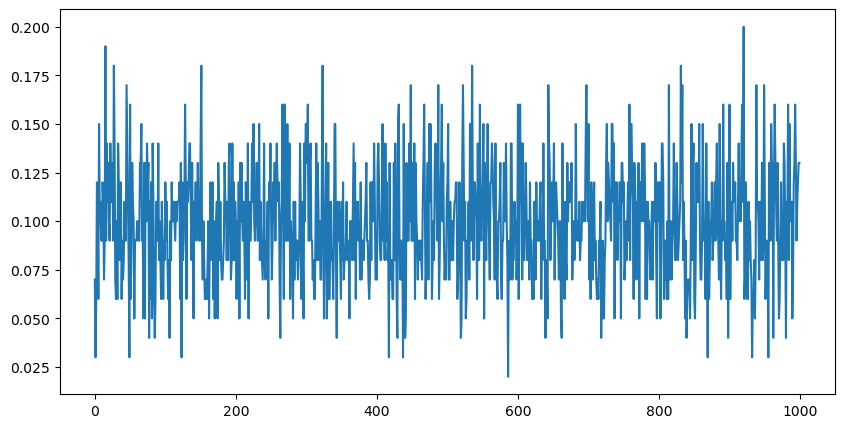

<Figure size 640x480 with 0 Axes>

In [19]:
data1 = data0.copy()
sampled_z_posterior=gibbs_z(data1, 1000, return_all_steps=True, seed=seed)

plt.figure(figsize=(10,5))
plt.plot([np.mean(x) for x in sampled_z_posterior])
plt.figure("Average of the components of the Z vector sampled at each iteration - 1000 iterations")
plt.show()

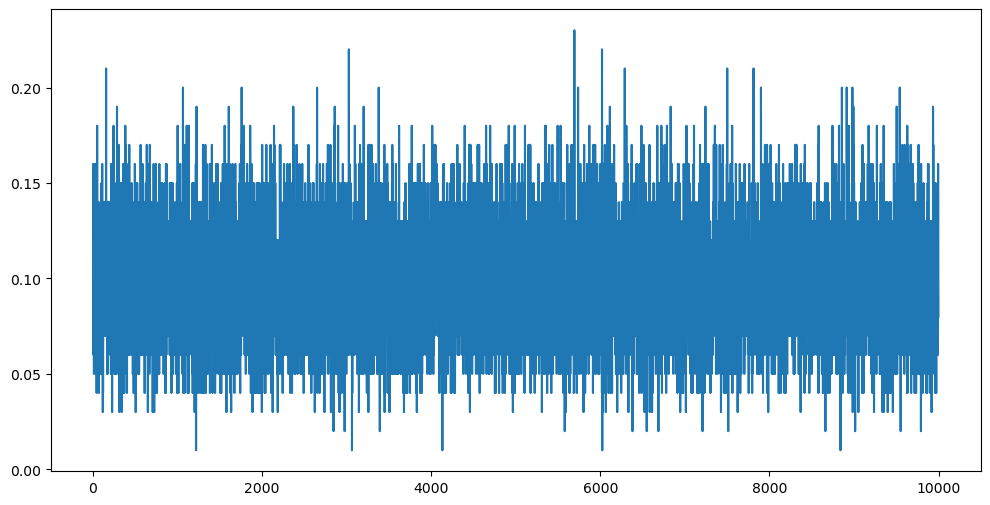

<Figure size 640x480 with 0 Axes>

In [20]:
data1 = data0.copy()
sampled_z_posterior=gibbs_z(data1, 10000, return_all_steps=True, seed=seed)

plt.figure(figsize=(12,6))
plt.plot([np.mean(x) for x in sampled_z_posterior])
plt.figure("Average of the components of the Z vector sampled at each iteration - 10 000 iterations")
plt.show()

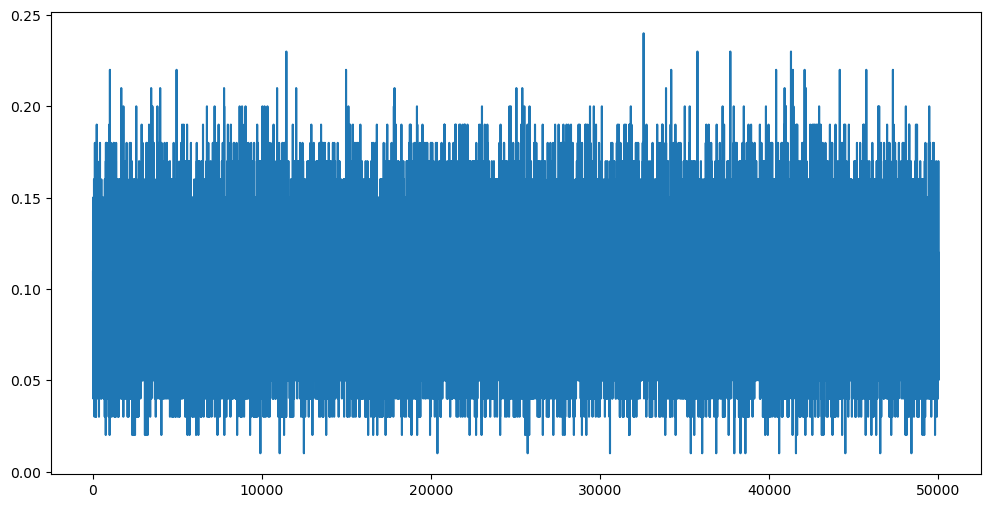

<Figure size 640x480 with 0 Axes>

In [21]:
data1 = data0.copy()
sampled_z_posterior=gibbs_z(data1, 50000, return_all_steps=True, seed=seed)

plt.figure(figsize=(12,6))
plt.plot([np.mean(x) for x in sampled_z_posterior])
plt.figure("Average of the components of the Z vector sampled at each iteration - 50 000 iterations")
plt.show()

The average value of the components of $z$ varies around 0.1. Significantly increasing the number of iterations does not reduce the variability of the variable. We therefore use 1000 iterations of the gibbs sampler to draw the variable $z$, according to its a posteriori distribution.

### 4. Draw from the conditional posterior of $\sigma^2$

In [26]:
def sample_sigma2_post(data: np.ndarray, n_variables: int) -> np.ndarray:
    """
    Sample from the posterior distribution of sigma2.

    Args:
        data (np.ndarray): Observed data.
        n_variables (int): Number of samples to draw.

    Returns:
        np.ndarray: Samples from the posterior distribution of sigma2.
    """
    k=int(data[0,0])
    X_tilde_t, W_tilde = compute_X_and_W_tilde(data[2,:k], data)
    
    inverse_gamma_dist = sp.stats.invgamma(T/2, scale=(1/2)*yy_minus_betah_w_betah(X_tilde_t, W_tilde, data))
    
    return inverse_gamma_dist.rvs(size=n_variables)

In [27]:
plot_hist(sample_sigma2_post(data0, 10000), 
          f"<b>First sample from the conditional posterior of Sigma2</b>"
         )

### 5. Draw from the conditional posterior of $\tilde{\beta}$

In [28]:
def sample_beta_tilde_post(data: np.ndarray, n_variables: int) -> np.ndarray:
    """
    Sample from the posterior distribution of beta tilde using the Gibbs sampling.

    Args:
        data (np.ndarray): Observed data.
        n_variables (int): Number of samples to draw.

    Returns:
        np.ndarray: Samples from the posterior distribution of beta tilde.
    """
    k=int(data[0,0])
    X_tilde_t, W_tilde = compute_X_and_W_tilde(data[2,:k], data)
    
    return np.random.multivariate_normal(
        np.linalg.inv(W_tilde)@X_tilde_t@data[1,:], #y
        data[0,11]*np.linalg.inv(W_tilde),  #sigma2
        n_variables
    )


In [29]:
plot_hist(sample_beta_tilde_post(data0, 10000), 
          f"<b>First samples from the conditional posterior of Beta tilde</b>"
         )


## Sample from $(R^2, q, \theta)$ posterior (Gibbs sampler)

Maintenant que l'on sait simuler séparément nos différentes variables d'intérêts, réutilisons le principe du Gibbs pour échantillonner selon la loi jointe $(R^2, q, \theta)$ par tirage et mise à jours successives.

In [42]:
def gibbs_sampler_joint_post(data0: np.ndarray, n_iter: int, n_iter_zi: int, seed: int, debug: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    """
    Gibbs sampler for the joint posterior distribution.

    Args:
        data0 (np.ndarray): Initial data.
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        n_iter_zi (int): Number of iterations for updating zi.
        debug (bool, optional): If True, return additional debugging information. Defaults to False.

    Returns:
        Tuple[np.ndarray, Optional[np.ndarray]]: Updated data and debug information (if debug=True).
    """
    data = data0.copy()
    R2_q_grid = get_R2_q_grid()
    k = int(data[0,0])
    vx = data[0,7]
    np.random.seed(int(data[0,6]))
    if debug:
        accu = np.zeros((n_iter, 5))
    
    for step in range(n_iter):
        
        if debug:
            accu[step, :2] = data[0,8:10].copy() # R2 and q
            accu[step, 3] = data[0,11].copy()  # sigma
            accu[step, 4] = np.mean(data[2,:]) # mean zi
        
        data[0,8:10] = sample_R2_q_post(R2_q_grid, data, 1) # update R2, q
        data[0,10] = compute_gamma2(data[0,8], data[0,9], k, vx) # update gamma2
        gibbs_z(data, n_iter_zi) #update z
        data[0,11] = sample_sigma2_post(data, 1) #update sigma2
        non_zero_z=np.nonzero(data[2,:k])[0]
        if non_zero_z.shape[0]>0:
            data[2,non_zero_z] = sample_beta_tilde_post(data, 1) #update beta tilde
    
    if debug:
        return data, accu
    return data, None

Testons maintenant la convergence de notre algorithme en récuppérant les valeurs intermédiaire du Gibbs par l'option debug du pipeline précédent.

In [44]:
n_iter = 10
n_iter_zi = 1000

t1 = t.time()
data, accu = gibbs_sampler_joint_post(data0, n_iter, n_iter_zi, debug=True, seed=seed)
t2 = t.time()

In [47]:
print(accu.shape)

(10, 5)


In [ ]:
fig = px.line(accu, template = "plotly_dark", title = f"<b>Gibbs for n_iter={n_iter} and n_iter_zi={n_iter_zi}</b> <br> R2, q, sigma2, mean(z) | {np.round(t2-t1, 3)}s")
fig.show()

## Exercice2

L'idée est ici de d'utiliser le pipeline précédent pour récupérer de l'échantillonage joint la valeure de q, ce qui revient à échantillonner selon la loi marginale à posteriori. Puis l'analyse consiste à modifier nos données initiales et à étudier l'impact de ces modification sur les valeurs de q et notamment sur sa valeure mediane.

La première étape est de stoquer plusieurs réalisations de q à partir de l'échantillonnage du 1.

In [ ]:
def get_q_from_gibbs(data0: np.ndarray, n_gibbs: int, n_iter: int, n_iter_zi: int) -> np.ndarray:
    """
    Get q values from multiple runs of the Gibbs sampler.

    Args:
        data0 (np.ndarray): Initial data.
        n_gibbs (int): Number of Gibbs sampler runs.
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        n_iter_zi (int): Number of iterations for updating zi.

    Returns:
        np.ndarray: Array of q values obtained from the Gibbs sampler runs.
    """
    res = np.zeros(n_gibbs)
    for j in range(n_gibbs):
        data, accu = gibbs_sampler_joint_post(data0, n_iter, n_iter_zi, debug=False)
        res[j] = data[0,9]
    return res

On peut test et récupérer la médiane de la manière suivante.

In [ ]:
n_gibbs = 10
n_iter = 10
n_iter_zi = 10

t1 = t.time()
q_array = get_q_from_gibbs(data0, n_gibbs, n_iter, n_iter_zi)
t2 = t.time()

C:\Users\samud\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
plot_hist(q_array, f"<b>Histogram de {n_gibbs} simulation de q n_iter={n_iter} and n_iter_zi={n_iter_zi} </b> median = {np.median(q_array)}| {np.round(t2-t1, 3)}s")

Maintenant nous modifions les données initiales et stockons les différentes collectes.

In [ ]:
def get_q_from_hyperpara(data0: np.ndarray, n_gibbs: int, n_iter: int, n_iter_zi: int, lst_s: List[float], lst_Ry: List[float]) -> Dict[str, np.ndarray]:
    """
    Get q values for various hyperparameters.

    Args:
        data0 (np.ndarray): Initial data.
        n_gibbs (int): Number of Gibbs sampler runs.
        n_iter (int): Number of iterations for updating R2, q, gamma2, and sigma2.
        n_iter_zi (int): Number of iterations for updating zi.
        lst_s (List[float]): List of hyperparameter values for s.
        lst_Ry (List[float]): List of hyperparameter values for Ry.

    Returns:
        Dict[str, np.ndarray]: Dictionary containing q values for different combinations of hyperparameters.
    """
    data1 = data0.copy()
    k = int(data1[0,0])
    T = data1.shape[1]
    res = {}
    
    for s in lst_s:
        data1[2,k:] = sample_beta(k, s) #beta
        data1[2,:k] = compute_Z(data1[2,k:])
        
        for Ry in lst_Ry:
            data1[0,11] = compute_sigma2(Ry, data1[2,k:], data1[3:,:].T) #sigma, X
            eps = sample_epsilon(T=T, sigma2=data1[0,11])
            data1[1,:] = compute_Y(X=data1[3:,:].T, beta=sample_beta(k, s), epsilon=eps)
            res[ f"s={s} Ry={Ry}"] = get_q_from_gibbs(data1, n_gibbs, n_iter, n_iter_zi)
    return res

Pour la visualisation nous passons d'un format de dictionnaire à un dataframe.

In [ ]:
n_gibbs = 10
n_iter = 10
n_iter_zi = 10

t1 = t.time()
dct_q_sRy = get_q_from_hyperpara(data0, n_gibbs, n_iter, n_iter_zi)
t2 = t.time()
df_res = pd.DataFrame(dct_q_sRy) 

C:\Users\samud\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
print("_________Medianes de q__________\n")
print(df_res.median())

_________Medianes de q__________

s=5 Ry=0.02      0.0040
s=5 Ry=0.25      0.0200
s=5 Ry=0.5       0.0565
s=10 Ry=0.02     0.0145
s=10 Ry=0.25     0.0020
s=10 Ry=0.5      0.0070
s=100 Ry=0.02    0.0100
s=100 Ry=0.25    0.0015
s=100 Ry=0.5     0.0105
dtype: float64


In [ ]:
plot_hist(df_res,f"<b>Histogramme de simulations de q par (s, Ry)</b> <br>n_gibbs = {n_gibbs}  n_iter={n_iter} n_iter_zi={n_iter_zi} {np.round(t2-t1, 3)}s")

In [ ]:
fig = px.box(df_res, template = "plotly_dark", title = f"<b>Boxplot de simulations de q par (s, Ry)</b> <br>n_gibbs = {n_gibbs}  n_iter={n_iter} n_iter_zi={n_iter_zi} {np.round(t2-t1, 3)}s")
fig.show()